In [16]:
import os
import tarfile #解压model

import numpy as np
import pandas as pd
from PIL import Image # 图像处理
import json

import tensorflow as tf
from collections import Counter 
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [17]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
                self.OUTPUT_TENSOR_NAME,
                feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

In [23]:
# cityscapes
LABEL_NAMES = ["road","sidewalk","building","wall","fence","pole","traffic light","traffic sign",
"vegetation","terrain","sky","person","rider","car","truck","bus","train","motorcycle","bicycle",]
def create_cityscapes_label_colormap():
    """Creates a label colormap used in CITYSCAPES segmentation benchmark.

    Returns:
        A colormap for visualizing segmentation results.
    """
    return np.asarray([
            [128, 64, 128],
            [244, 35, 232],
            [70, 70, 70],
            [102, 102, 156],
            [190, 153, 153],
            [153, 153, 153],
            [250, 170, 30],
            [220, 220, 0],
            [107, 142, 35],
            [152, 251, 152],
            [70, 130, 180],
            [220, 20, 60],
            [255, 0, 0],
            [0, 0, 142],
            [0, 0, 70],
            [0, 60, 100],
            [0, 80, 100],
            [0, 0, 230],
            [119, 11, 32],
    ])

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_cityscapes_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

def vis_segmentation(image, seg_map,path):
    """Visualizes input image, segmentation map and overlay view."""
    # 文件的可可视化
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    print(unique_labels)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), [LABEL_NAMES[i] for i in unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()
    # 文件的保存
    p1,p2=os.path.splitext(path)
    image.save(p1+'_resized'+p2)
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    Image.fromarray(seg_image).save(p1+'_seg'+p2)
    Image.fromarray(np.uint8(np.asarray(seg_image)*0.7+np.asarray(image)*0.3)).save(p1+'_overlay'+p2)
    # 各种图片所占比例的可视化
    calc = {}
    for key,value in Counter(seg_map.flatten()).items():
        print(LABEL_NAMES[key],round(value/seg_map.flatten().shape[0]*100,4))

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

model loaded successfully!
running deeplab on image deeplab_v3_plus/example.png...
[ 0  1  2  5  8  9 10 13 17]


C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


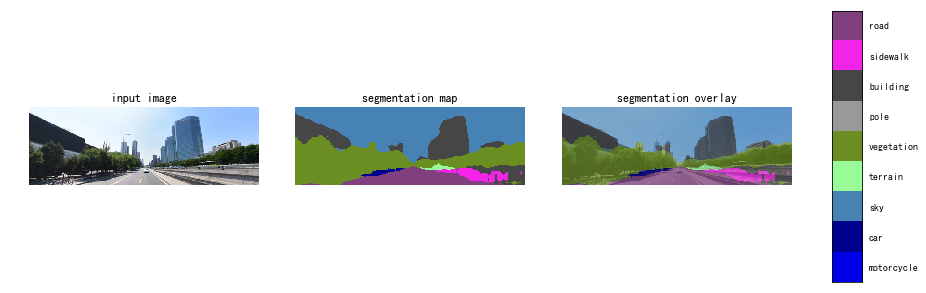

sky 40.669
building 17.1417
vegetation 29.0628
pole 0.0022
terrain 0.6274
road 8.9086
car 0.7293
motorcycle 0.0045
sidewalk 2.8545


In [24]:
MODEL = DeepLabModel('deeplab_v3_plus/model/deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz')
print('model loaded successfully!')

def run_visualization(path):
    """Inferences DeepLab model and visualizes result."""
    try:
        original_im = Image.open(path)
    except IOError:
        print('Cannot retrieve image. Please check url: ' + url)
        return

    print('running deeplab on image %s...' % path)
    resized_im, seg_map = MODEL.run(original_im)
    vis_segmentation(resized_im, seg_map,path)

run_visualization('deeplab_v3_plus/example.png')